# Анализ объявлений по продаже автомобилей с auto.drom.ru 

Участники группы: Щеглов Алексей, Байгужин Искандер, Зверев Алексей

# Шаг 2: Сбор данных

__1. Соберем данные, спарсив их с auto.drom.ru, возьмем 2000 объявлений, которые находятся на первых 100 страницах сайта__


In [462]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy.stats as sts
import numpy as np
from statsmodels.stats.weightstats import ztest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

In [463]:
def get_page(p):
    url = 'https://auto.drom.ru/all/page{}/?minpower=50'.format(p) #ссылка дрома, с которой парсим
    response = requests.get(url)
    tree = BeautifulSoup(response.content, 'html.parser')
    books = tree.find_all('a', {"class": "css-4zflqt e1huvdhj1"})

    infa = []

    for book in books:
        pric = book.find('span', {"class": "css-46itwz e162wx9x0"}).text[0:-2]
        price = int(pric.replace('\xa0', ''))
        try:
            info = book.find('div', {"class": "css-16kqa8y e3f4v4l2"}).text
        except:
            info = book.find('div', {"class": "css-d4igzo e3f4v4l2"}).text
        year = int(info.split(',')[1])
        model = info.split(',')[-2]
        dvig = list(book.find('span', {'class' : "css-1l9tp44 e162wx9x0"}))[0]
        volume = float(dvig[:3])
        if volume < 10:
            volume = volume
        else:
            volume = 0
        hors = dvig[-9:-5]
        horse = int(hors.strip('('))
        tip = book.find_all('span', {'class' : "css-1l9tp44 e162wx9x0"})[1].text
        typpe = tip.strip(',')
        try:
            corob = book.find_all('span', {'class' : "css-1l9tp44 e162wx9x0"})[2].text
            box = corob.strip(',')
            if box == 'АКПП' or box == 'вариатор' or box == 'механика' or box == 'автомат' or box == 'робот Коробка':
                box = box #разбиваем коробку на ее виды
            else:
                box = None #исключаем "корявые" переменные, где было указано слишком мало показателей и все данные не на своих местах            
        except:
            box = None           
        prob = book.find_all('span', {'class' : "css-1l9tp44 e162wx9x0"})[-1].text.strip(' км')
        try:
            probeg = int(prob.replace(' ', ''))
        except:
            probeg = 0 #делаем ноль, потому что чаще всего это новые машины, и лишь иногда у машин просто не указан пробег
        try:
            priv = book.find_all('span', {'class' : "css-1l9tp44 e162wx9x0"})[3].text
            privod = priv.strip(',')
            if privod == 'задний' or privod == 'передний' or privod == '4WD':
                privod = privod #разбиваем привод на его типы
            else:
                privod = None #исключаем "корявые" переменные, где было указано слишком мало показателей и все данные не на своих местах
        except:
            privod = None
        infa.append({'Цена': price, 'Год': year, 'Модель' : model, 'Двигатель, л' : volume, 'ЛС': horse, 'Коробка': box, 'Тип': typpe, 'Привод': privod, 'Пробег, км': probeg})

    return infa

infa = []

for p in range(1, 101):
    infa.extend(get_page(p))

df = pd.DataFrame(infa)
print(df.shape)
df

(2000, 9)


,Цена,Год,Модель,"Двигатель, л",ЛС,Коробка,Тип,Привод,"Пробег, км"
0,1200000,1998,Mercedes-Benz SLK-Class,2.3,193,АКПП,бензин,задний,217000
1,850000,2010,Toyota Prius,1.8,99,вариатор,гибрид,передний,355700
2,1699000,2015,Hyundai H1,2.5,116,механика,дизель,задний,124000
3,11650000,2022,BMW iX,0.0,619,АКПП,электро,4WD,13500
4,6700000,2021,Dodge Challenger,6.4,485,АКПП,бензин,задний,20000
...,...,...,...,...,...,...,...,...,...
1995,3700000,2020,Hyundai Palisade,3.8,295,АКПП,бензин,передний,48000
1996,155000,2001,Лада 2107,1.6,72,механика,бензин,задний,4
1997,670000,2002,Mitsubishi Outlander,2.4,142,АКПП,бензин,передний,226000
1998,3190000,2014,Nissan Patrol,5.6,405,АКПП,бензин,4WD,162000


In [464]:
df

,Цена,Год,Модель,"Двигатель, л",ЛС,Коробка,Тип,Привод,"Пробег, км"
0,1200000,1998,Mercedes-Benz SLK-Class,2.3,193,АКПП,бензин,задний,217000
1,850000,2010,Toyota Prius,1.8,99,вариатор,гибрид,передний,355700
2,1699000,2015,Hyundai H1,2.5,116,механика,дизель,задний,124000
3,11650000,2022,BMW iX,0.0,619,АКПП,электро,4WD,13500
4,6700000,2021,Dodge Challenger,6.4,485,АКПП,бензин,задний,20000
...,...,...,...,...,...,...,...,...,...
1995,3700000,2020,Hyundai Palisade,3.8,295,АКПП,бензин,передний,48000
1996,155000,2001,Лада 2107,1.6,72,механика,бензин,задний,4
1997,670000,2002,Mitsubishi Outlander,2.4,142,АКПП,бензин,передний,226000
1998,3190000,2014,Nissan Patrol,5.6,405,АКПП,бензин,4WD,162000


# Шаг 3: Предварительныя обработка

В коде парсинга мы уже провели некую обработку данных, чтобы с ними было удобно работать, а также разбили данные на переменные

__Описание переменных:__

* `Цена` - указанная стоимость автомобиля в объявлении в рублях
* `Год` - год автомобиля 
* `Модель` - модель автомобиля 
* `Двигатель (л)`  - объем двигателя в литрах
* `ЛС`  - количество лошадиных сил
* `Коробка` - тип коробки передач
* `Тип` - тип двигателя (топливо)
* `Привод` - привод автомобиля
* `Пробег, км` - указанный пробег автомобиля в км


##### Не во всех объявлениях указывают полностью все компоненты, взятые нами для анализа, поэтому мы написали код, который заменяет отсутствующую компоненту на пустоту(чаще всего не указывают коробку и привод), это можно увидеть ниже

In [465]:
df.isna().sum()

Цена             0
Год              0
Модель           0
Двигатель, л     0
ЛС               0
Коробка         95
Тип              0
Привод           1
Пробег, км       0
dtype: int64

In [466]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Цена          2000 non-null   int64  
 1   Год           2000 non-null   int64  
 2   Модель        2000 non-null   object 
 3   Двигатель, л  2000 non-null   float64
 4   ЛС            2000 non-null   int64  
 5   Коробка       1905 non-null   object 
 6   Тип           2000 non-null   object 
 7   Привод        1999 non-null   object 
 8   Пробег, км    2000 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 140.8+ KB


##### Так как в объявлениях встречаются электрокары, у которых не указан литраж двигателя, заменим 'электро' на пустоту

In [467]:
df.loc[df['Тип'] == 'электро', 'Двигатель, л'] = None

##### Теперь удалим пустые значения. Таким образом, мы избавимся от "корявых" объявлений, а так же от электрокаров. Удалить электрокары нам посоветовал ассистент: их получается всего около 20 штук, и их удаление не окажет серьёзного влияния на выборку.

In [468]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Цена          2000 non-null   int64  
 1   Год           2000 non-null   int64  
 2   Модель        2000 non-null   object 
 3   Двигатель, л  1987 non-null   float64
 4   ЛС            2000 non-null   int64  
 5   Коробка       1905 non-null   object 
 6   Тип           2000 non-null   object 
 7   Привод        1999 non-null   object 
 8   Пробег, км    2000 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 140.8+ KB


In [469]:
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [470]:
df

,Цена,Год,Модель,"Двигатель, л",ЛС,Коробка,Тип,Привод,"Пробег, км"
0,1200000,1998,Mercedes-Benz SLK-Class,2.3,193,АКПП,бензин,задний,217000
1,850000,2010,Toyota Prius,1.8,99,вариатор,гибрид,передний,355700
2,1699000,2015,Hyundai H1,2.5,116,механика,дизель,задний,124000
3,6700000,2021,Dodge Challenger,6.4,485,АКПП,бензин,задний,20000
4,1860000,2021,Kia Rio X (X-Line),1.6,123,АКПП,бензин,передний,51700
...,...,...,...,...,...,...,...,...,...
1887,3700000,2020,Hyundai Palisade,3.8,295,АКПП,бензин,передний,48000
1888,155000,2001,Лада 2107,1.6,72,механика,бензин,задний,4
1889,670000,2002,Mitsubishi Outlander,2.4,142,АКПП,бензин,передний,226000
1890,3190000,2014,Nissan Patrol,5.6,405,АКПП,бензин,4WD,162000


# Шаг 4: Визуализация

##### Построим гистограммы для всех признаков, кроме "моделей", так как их слишком много

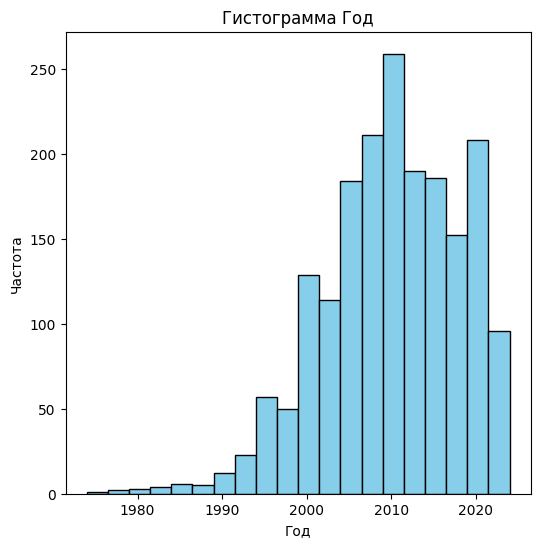

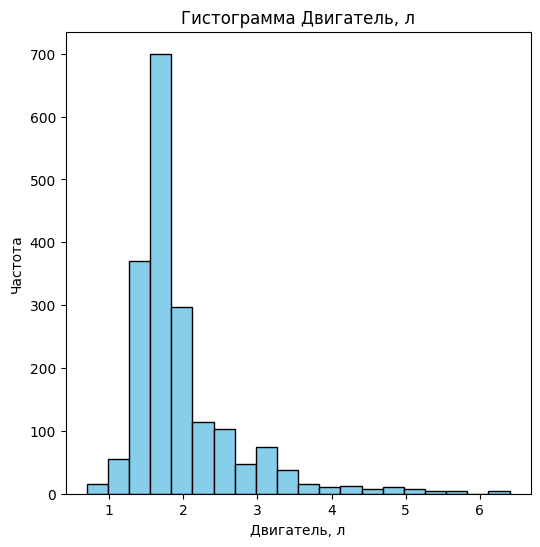

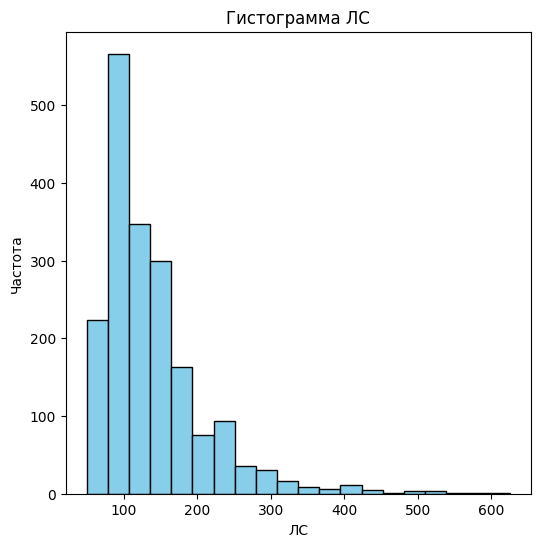

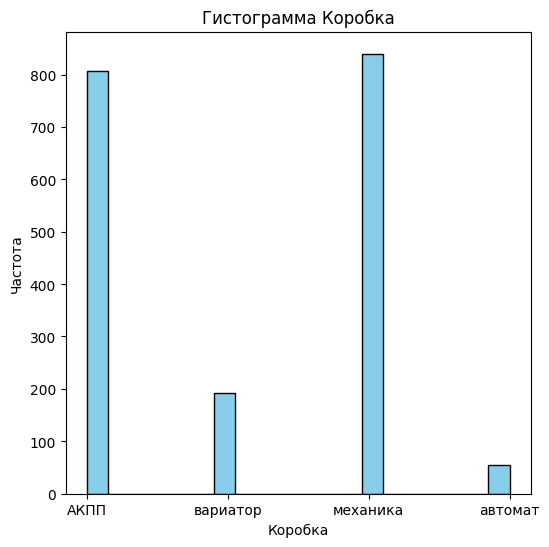

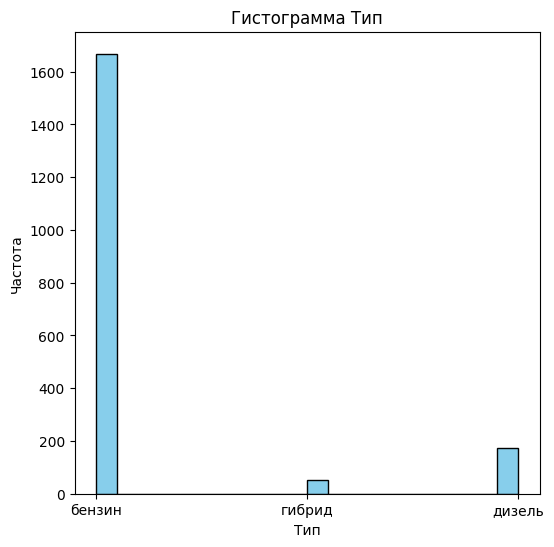

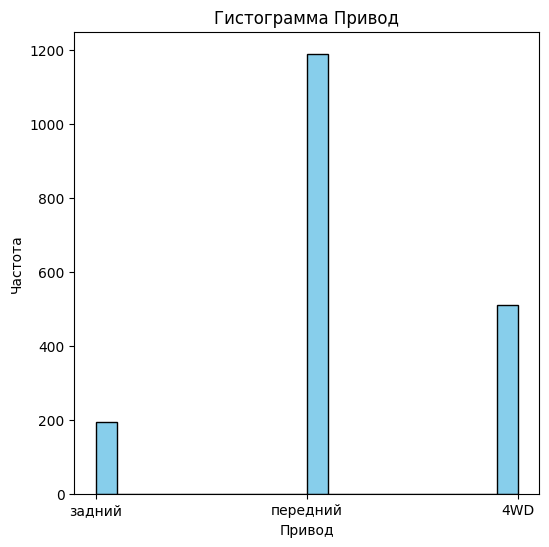

In [471]:
for column in df.columns:
    if column != 'Модель' and column != 'Пробег, км' and column != 'Цена': 
        plt.figure(figsize=(6, 6))
        plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.title(f'Гистограмма {column}')

##### Промежуточный вывод: больше всего в объявлениях встречаются поддержанные автомобили 2010-ых годов, объемом двигателя от 1,5 до 2 л, имеющие около 100 лс, коробкой АККП и чуть меньше с механикой на бензине с передним приводом.

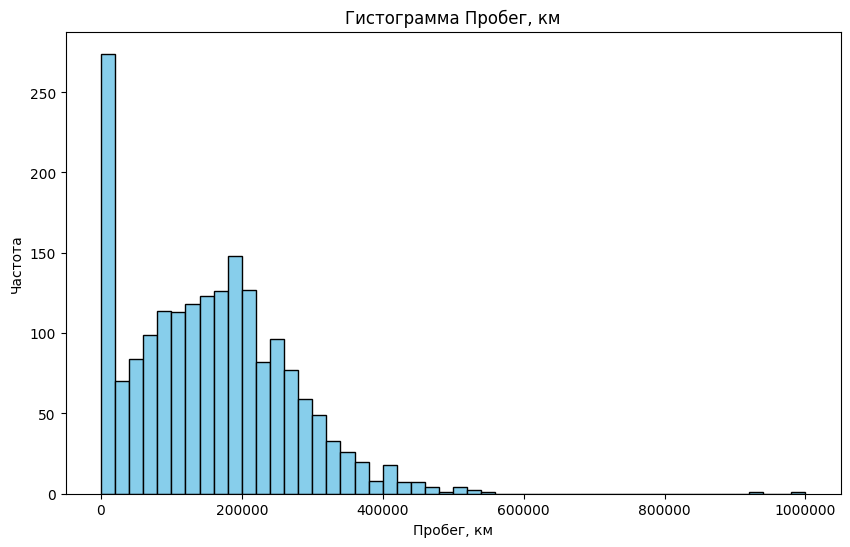

In [472]:
plt.figure(figsize=(10, 6))
plt.hist(df['Пробег, км'], bins=50, color='skyblue', edgecolor='black', log=False)
plt.ticklabel_format(style='plain', axis='x')# Добавляем log=False
plt.xlabel('Пробег, км')
plt.ylabel('Частота')
plt.title(f'Гистограмма Пробег, км')
plt.show() 


##### По гистограмме пробега, можно заметить, что это в среднем в объявлениях встречаются машины с пробегом до 300.000 км, однако также очень ярко выражены совсем новые автомобили без пробега 

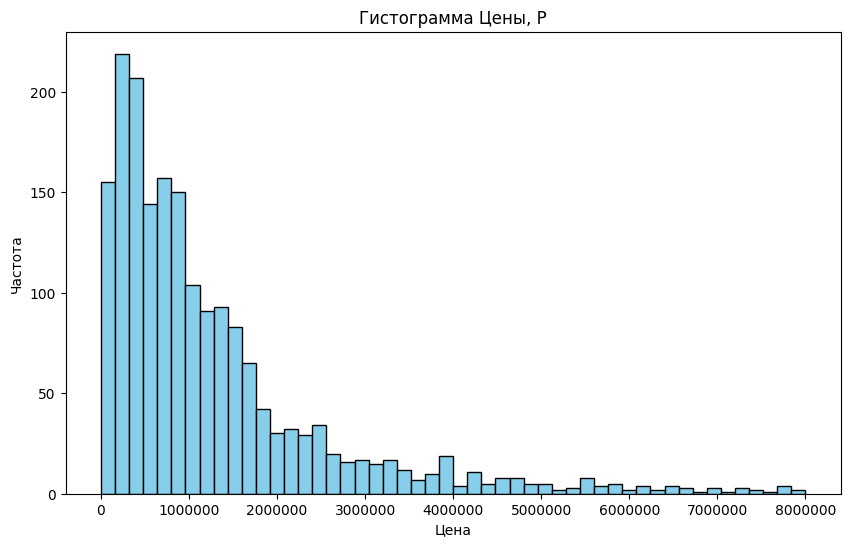

In [473]:
plt.figure(figsize=(10, 6))
plt.hist(df['Цена'], bins=50, color='skyblue', edgecolor='black', log=False, range=(0, 8000000))
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title(f'Гистограмма Цены, Р')
plt.show() 

##### По гистограмме цены автомобилей можно заметить, что она имеет распределение схожее с Пуассоновским. В выборке наиболее часто встречаются автомобили до 1.000.000 рублей


__Посмотрим, как распределены цены автомобилей в зависимости от каждого из признаков__

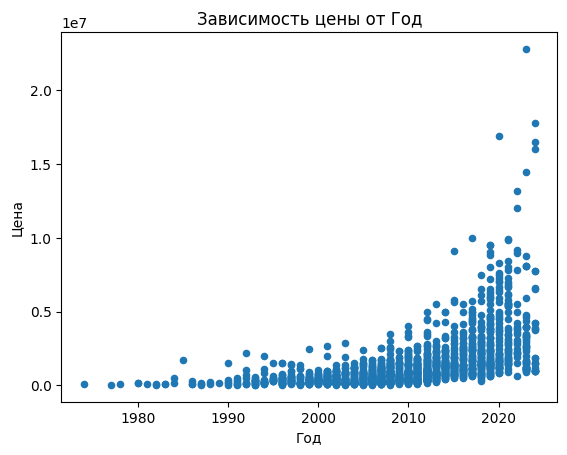

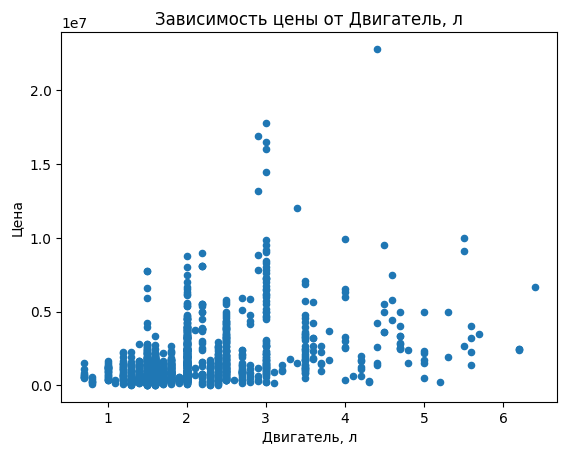

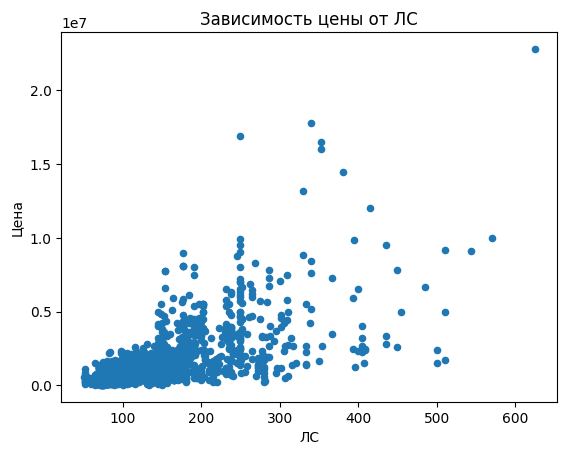

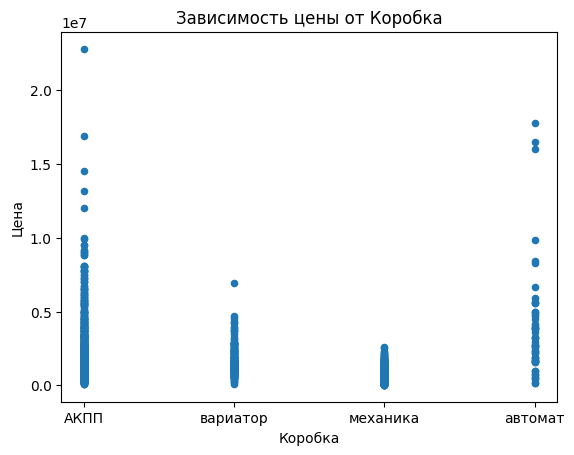

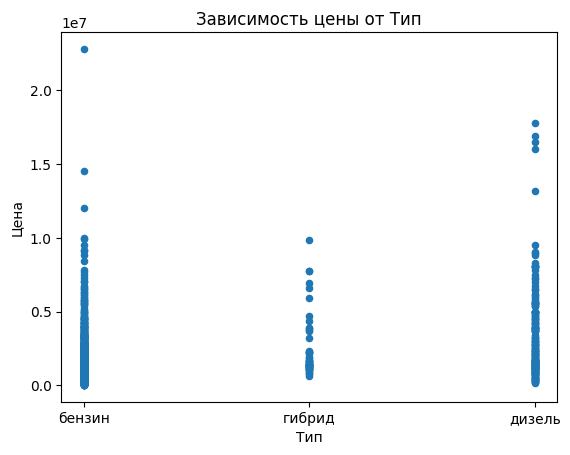

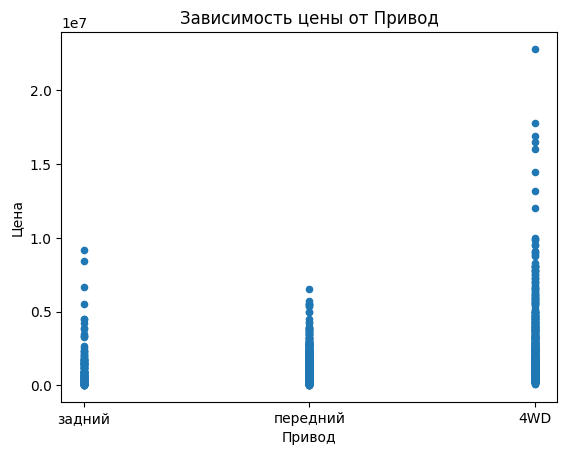

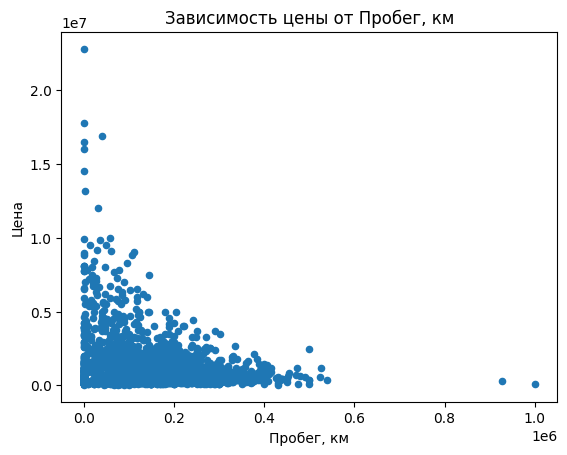

In [474]:
for column in df.columns:
    if column != 'Цена' and column != 'Модель' :  
        df.plot(x=column, y='Цена', kind='scatter')
        plt.xlabel(column)
        plt.ylabel('Цена')
        plt.title(f'Зависимость цены от {column}')
        plt.show()

##### Мы видим, что чем новее машина - тем она дороже. Причём зависимость выглядит как начало экспоненциальной. Интересно.

##### Так же можно проследить, что механика стоит дешевле других. Проверим это позднее на гипотезе

##### Зависимость цены от пробега тоже принимает вид "начала" экспоненциальной зависимости, только обратной.

### Отдельно посмотрим распределение цен машин в зависимости от привода:

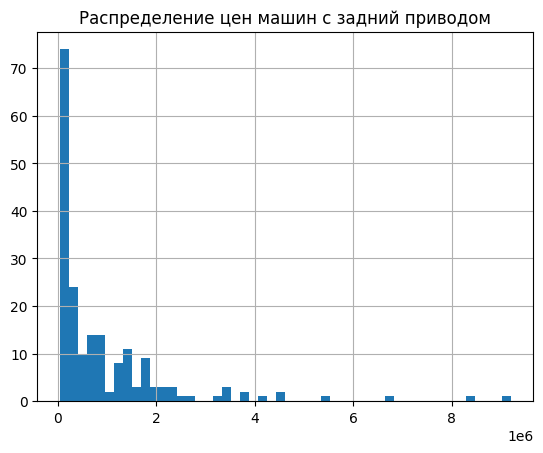

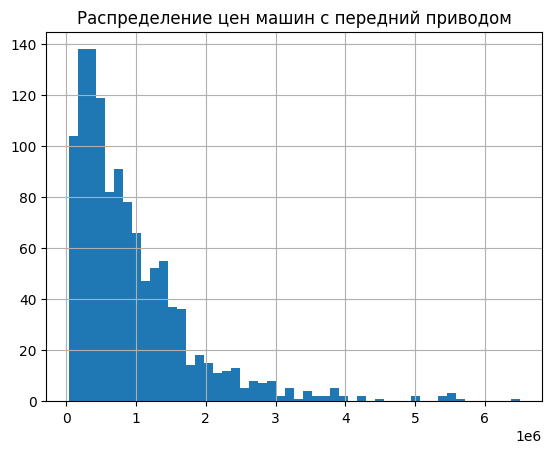

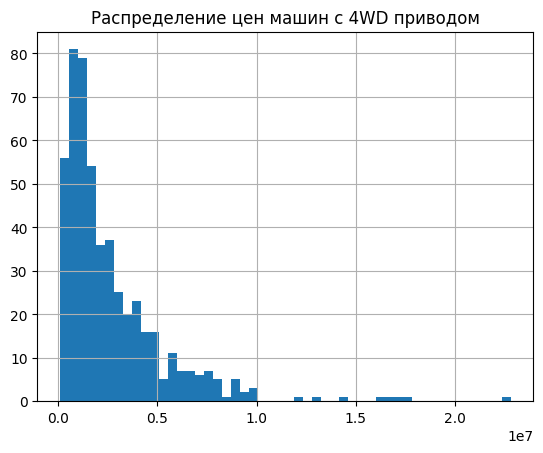

In [475]:
for i in df['Привод'].unique():
    dfnew=df[df['Привод']==i]
    dfnew.hist('Цена', bins=50, log=False)
    plt.title(f'Распределение цен машин с {i} приводом')
    plt.show()

##### Мы видим, что машины с полным приводом стоят на порядок дороже, чем автомобили с другим приводом. Это мы тоже выдвинем как гипотезу.

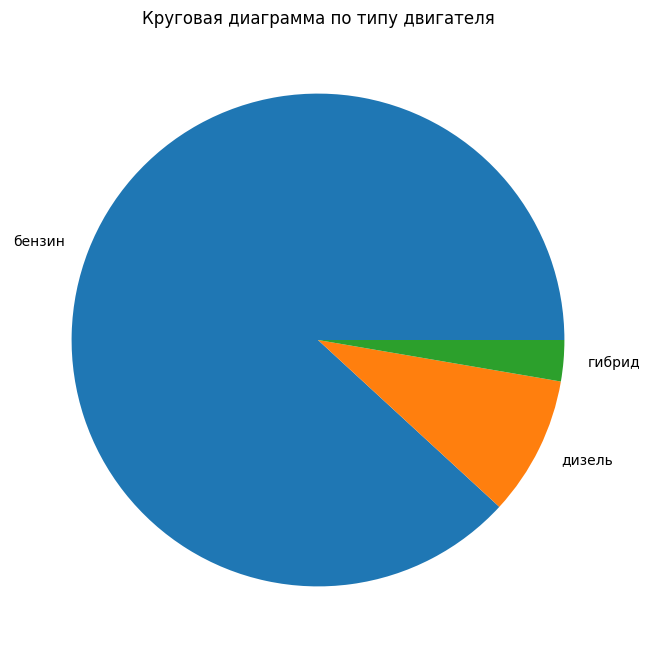

In [476]:
df['Тип'].value_counts().plot(kind='pie', figsize=(8, 8))
plt.title("Круговая диаграмма по типу двигателя")
plt.ylabel("")
plt.show()

##### Круговая дигарамма по типу двигателя - еще один вид хорошей визуализации того, что большую долю в объявлениях занимают машины на бензине, в то время как гибрид и дизель представлен гораздо слабее.

Построим ящик с усами, который покажет выбросы цены в зависимости от типа двигателя

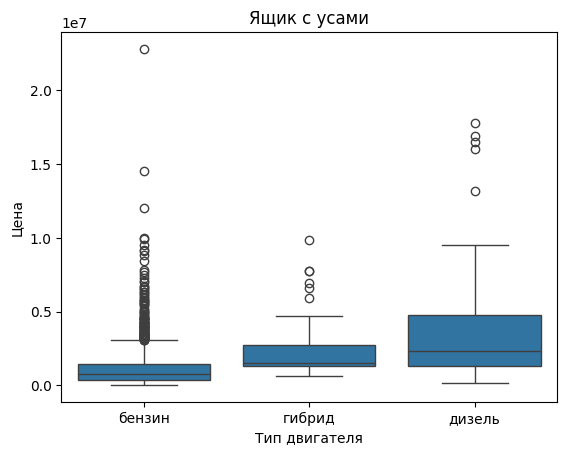

In [477]:
sns.boxplot(x='Тип', y='Цена', data=df)

plt.xlabel('Тип двигателя')
plt.ylabel('Цена')
plt.title('Ящик с усами');

##### Отчетливо видно, что машины с бензиновым двигателем имеют больше выбросов, чем какие либо другие, что логично, ведь именно с этим типом двигателя наибольшее количество объявлений

##### Далее построим корреляционную матрицу данных

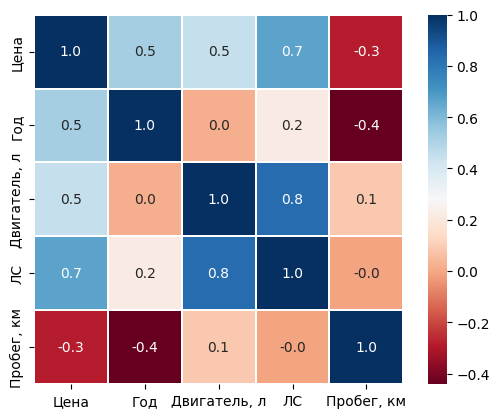

In [478]:
num_columns = df.select_dtypes(include=['int64', 'float64']).columns

sns.heatmap(df[num_columns].corr(method='pearson'), 
            square=True, annot=True, fmt=".1f", 
            linewidths=0.1, cmap="RdBu");

##### Из матрицы видны логичные вещи, к примеру, то, что пробег и цена, пробег и год имеют отрицательные зависимости. Скорее всего, именно эти критерии имеют приоритет при выборе автомобиля. Так же корреляция года и цены аж 0.5.

# Шаг 5: Создание новых признаков

### 1) Налог в зависимости от лошадиных сил 

###### Мы решили рассчитать этот показатель, так как он может оказывать влияние на цену. Налоги всегда закладываются в окончательное ценообразование машины. 

###### Также этот показатель логично вписывается в наш ресёрч

In [479]:
def calculate_tax(power):
    if power <= 100:
        return 25*power
    elif power <= 150:
        return 35*power
    elif power <= 200:
        return 50*power
    elif power <= 250:
        return 75*power
    else:
        return 150*power

df['Налог, руб'] = df['ЛС'].apply(calculate_tax)

### 2) Средний расход топлива в зависимости от объема двигателя:

###### Этот показатель тоже принимают во внимание при покупке машины. Средний расход топлива влечёт за собой дополнительные ежемесячные траты на машину, которые так же должны быть учтены в ценообразовании автомобиля

In [480]:
def calculate_rashod(volume):
    if volume <= 1.2:
        return 5
    elif 1.2 <= volume <= 1.8:
        return 7
    elif 1.8 <= volume <= 3:
        return 10
    elif 3 <= volume:
        return 15
    else:
        return None
    
df['Ср.расход, л/100км'] = df['Двигатель, л'].apply(calculate_rashod)

# Шаг 6: Гипотезы

__Выдвижение гипотез и их проверка__

In [481]:
level=0.01 #уровень значимости

def test_na_norm(sample1, sample2, ax): #тест Колмогорова-Смирнова на нормальность распрделения
    
    res1=sts.kstest(sample1[ax], 'norm')[1]
    res2=sts.kstest(sample2[ax], 'norm')[1]
    
    if res1<level: 
        print('Первая выборка не имеет нормальное распределение')
    else: 
        print('Первая выборка имеет нормальное распределение')
        
    if res2<level: 
        print('Вторая выборка не имеет нормальное распределение')
    else: 
        print('Вторая выборка имеет нормальное распределение')
        
def u_test(sample1, sample2, ax, method): #u-test, на случай если распределения не нормальное. Переменная method отвечает за то, какую гипотезу H1 мы будем проверять
    pvalue = sts.mannwhitneyu(sample1[ax], sample2[ax], alternative=method)[1]
    
    if pvalue<level: 
        print('Нулевая гипотеза отвергается в пользу альтернативной')
    else: 
        print('Нулевая гипотеза принимается (альтернативная отвергается)')
        
def z_test(sample1, sample2, ax, method): #z-test, если распределения нормальные. Переменная method отвечает за то, какую гипотезу H1 мы будем проверять
    pvalue = ztest(sample1[ax], sample2[ax], alternative=method)[1]
    
    if pvalue<level: 
        print('Нулевая гипотеза отвергается в пользу альтернативной')
    else: 
        print('Нулевая гипотеза принимается (альтернативная отвергается)')

### Гипотеза №1. БМВ дороже других автомобилей

In [482]:
df['BMW']=df['Модель'].apply(lambda x: 1 if 'BMW' in x else 0)
dfBMW=df[df['BMW']==1]
dfNonBMW=df[df['BMW']==0]
df.drop('BMW', axis=1, inplace=True)

In [483]:
test_na_norm(dfBMW, dfNonBMW, 'Цена')

Первая выборка не имеет нормальное распределение
Вторая выборка не имеет нормальное распределение


##### тогда испольщуем U-тест

In [484]:
u_test(dfBMW, dfNonBMW, 'Цена', 'greater')

Нулевая гипотеза отвергается в пользу альтернативной


Итак, мы протестировали нашу гипотезу о том, что БМВ дороже других автомобилей, и она подтвердилась. Этот результат ожидаемый, т.к. много продаваемых машин на сайте всё же немного иного ценового сегмента, чем БМВ. Конечно, есть и Mercedes, и Audi, но так же продаётся и много "классических" семейных недорогих иномарок

### Гипотеза №2. Цена никак не зависит от пробега. Проверим с помощью критерия независимости ХиКвадрат

In [485]:
dfPriceProb=df[['Цена', 'Пробег, км']]
pvalue=sts.chi2_contingency(dfPriceProb)[1]
if pvalue<level:
    print('Нулевая гипотеза о независимости отвергается')
else:
    print('Нулевая гипотеза о независимости не отвергается')

Нулевая гипотеза о независимости отвергается


Соответсвенно, цена на автомобиль зависит от пробега. Что, конечно же, правда. Эти два распределения не являются независимыми.

### Гипотеза №3. Дизельные двигатели имеют больше лошадиных сил, чем иные двигатели.

In [486]:
dfPetrol=df[df['Тип']=='дизель']
dfOther=df[df['Тип']!='дизель']

In [487]:
test_na_norm(dfPetrol, dfOther, 'ЛС')

Первая выборка не имеет нормальное распределение
Вторая выборка не имеет нормальное распределение


##### тогда испольщуем U-тест

In [488]:
u_test(dfPetrol, dfOther, 'ЛС', 'greater')

Нулевая гипотеза отвергается в пользу альтернативной


Следовательно, и вправду прослеживается такая тенденция. Дизельные двигатели имеют больше ЛС чем машины другого типа.

### Гипотеза №4. Машины с механикой стоят меньше, чем машины с автоматом.

In [489]:
dfMech=df[df['Коробка']=='механика']
dfAuto=df[df['Коробка']=='автомат']

In [490]:
test_na_norm(dfMech, dfAuto, 'Цена')

Первая выборка не имеет нормальное распределение
Вторая выборка не имеет нормальное распределение


#### используем U-тест

In [491]:
u_test(dfMech, dfAuto, 'ЛС', 'less')

Нулевая гипотеза отвергается в пользу альтернативной


То есть, гипотеза H0 о том, **что выборки одинаковы** ***отвергается*** в пользу того, что машины с механической коробкой стоят дешевле. Значит, наша выдвинутая гипотеза верна: механика стоит дешевле.

Может это проверить, задав другую альтернативную гипотезу:

In [492]:
u_test(dfMech, dfAuto, 'ЛС', 'greater')

Нулевая гипотеза принимается (альтернативная отвергается)


И вправду: здесь нулевая гипотеза уже не отвергается в пользу альтернативной гипотезы, что механика стоит дороже. Это подверждает выводы выше

### Гипотеза №5. Ценообразование машин с полным приводом отличается от ценообразования других типов машин.

In [493]:
df4WD=df[df['Привод']=='4WD']
dfNon4WD=df[df['Привод']!='4WD']

In [494]:
test_na_norm(df4WD, dfNon4WD, 'Цена')

Первая выборка не имеет нормальное распределение
Вторая выборка не имеет нормальное распределение


In [495]:
u_test(df4WD, dfNon4WD, 'Цена', 'two-sided')

Нулевая гипотеза отвергается в пользу альтернативной


##### Следовательно, цена на машины меняется в зависимости от привода. У полного привода цена устанавливается по-другому, нежели чем у переднего или заднего. Нам интересно было это проверить, так как это не очень очевидно. 

# Шаг 7: Машинное обучение

**Надо удалить модели машин, так как при OHE получилось бы огромное количество столбцов с различными моделями**

In [496]:
df.drop('Модель', axis=1, inplace=True)

In [497]:
var_cat=df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, drop_first = True, dtype=float, columns = var_cat)
df

,Цена,Год,"Двигатель, л",ЛС,"Пробег, км","Налог, руб","Ср.расход, л/100км",Коробка_автомат,Коробка_вариатор,Коробка_механика,Тип_гибрид,Тип_дизель,Привод_задний,Привод_передний
0,1200000,1998,2.3,193,217000,9650,10,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,850000,2010,1.8,99,355700,2475,7,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1699000,2015,2.5,116,124000,4060,10,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,6700000,2021,6.4,485,20000,72750,15,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1860000,2021,1.6,123,51700,4305,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1887,3700000,2020,3.8,295,48000,44250,15,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1888,155000,2001,1.6,72,4,1800,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1889,670000,2002,2.4,142,226000,4970,10,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1890,3190000,2014,5.6,405,162000,60750,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Разобьем выборку на тренировочную и тестовую**

In [498]:
df_train, df_test = train_test_split(df, test_size = 0.2)

y_train = df_train['Цена']
y_test = df_test['Цена']

X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)
feature_names = df_train.drop('Цена', axis=1).columns
X_test

,Год,"Двигатель, л",ЛС,"Пробег, км","Налог, руб","Ср.расход, л/100км",Коробка_автомат,Коробка_вариатор,Коробка_механика,Тип_гибрид,Тип_дизель,Привод_задний,Привод_передний
1255,2008,1.6,80,263000,2000,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1467,2012,1.6,105,193000,3675,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0
394,2017,2.5,181,147000,9050,10,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1403,2012,1.6,123,121000,4305,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1871,2012,1.6,105,251000,3675,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,2018,2.5,203,97000,15225,10,0.0,0.0,0.0,0.0,0.0,0.0,1.0
696,2015,1.6,110,137000,3850,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45,2020,2.5,185,21000,9250,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1869,2017,1.6,106,20100,3710,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0


**Приведем данные к одному масштабу, то есть отнормируем, чтобы на протяжении всего процесса обучения это гарантировало, что каждая функция вносит одинаковый вклад, не позволяя функциям большего масштаба затмевать другие**

In [499]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train[feature_names])
X_test_scaled = scaler_x.transform(X_test[feature_names])

## Оценим линейную регрессию

In [500]:
model = LinearRegression()
res = model.fit(X_train_scaled, y_train) #Обучили модель на тренировочной выборке 
#Сделали прогнозы на тестовой выборке
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

In [501]:
mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred) 
print(f'Значение RMSE: {rmse}') 
print(f'Значение MAE: {mae}')
print(f'Значение R^2: {r2}')
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Значение RMSE: 1074507.2436865238
Значение MAE: 577258.8440907084
Значение R^2: 0.6422793084824832
Test MAPE = 0.9285
Train MAPE = 0.9706


В среднем наши прогнозы отклоняются от целевых показателей на 1%, что обычно рассматривается как очень хорошее значение.

**Создадим таблицу с весами**

In [502]:
table_coef = pd.DataFrame(data=res.coef_, index=feature_names, columns=['Coef'])
table

,Coef
Год,4.204792e+05
"Двигатель, л",-4.002056e+05
ЛС,1.652139e+06
"Пробег, км",-2.456637e+05
"Налог, руб",-8.396428e+04
Тип_гибрид,1.790077e+05
Тип_дизель,3.058849e+05
Привод_задний,-1.639604e+05
Привод_передний,-1.700894e+05
Коробка_автомат,1.492175e+05


**Вывод:** Как мы можем увидеть, веса у каждого из коэффициентов получились огромными, что возможно говорит о переобученности и нестабильности нащей модели. Однако, возможен вариант нелийной связи наших переменных

### Полиномиальная регрессия

In [503]:
from sklearn.preprocessing import PolynomialFeatures

polinom_transform = PolynomialFeatures(2, include_bias=False)

X_train_poly = polinom_transform.fit_transform(X_train_scaled)
X_test_poly = polinom_transform.transform(X_test_scaled)
X_train_poly.shape

(1513, 104)

In [504]:
model = LinearRegression()

model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred) 
print(f'Значение RMSE: {rmse}') 
print(f'Значение MAE: {mae}')
print(f'Значение R^2: {r2}')
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Значение RMSE: 748419.9247078889
Значение MAE: 422725.5211081794
Значение R^2: 0.8264534245391948
Test MAPE = 0.5633
Train MAPE = 0.4802


Возможно, наши данные с низкой дисперсией, то есть, фактические значения не сильно отличаются друг от друга. В этом случае модель может легко "подогнаться" к данным, даже с большими коэффициентами, и  получить низкий MAPE. **Необходимо попробовать регуляризацию** 

## LASSO

In [505]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=200)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred) 
print(f'Значение RMSE: {rmse}') 
print(f'Значение MAE: {mae}')
print(f'Значение R^2: {r2}')
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))
model.coef_

Значение RMSE: 1074617.2208278028
Значение MAE: 577145.1829302316
Значение R^2: 0.6422060784273753
Test MAPE = 0.9284
Train MAPE = 0.9704


array([ 483060.55910059, -209308.04652413, 1053327.04760807,
       -237675.98567585,   58019.44889193,  -65161.42344306,
        105997.38750428,  -25770.78854993,  -98645.71469352,
        138490.80852812,  342392.45160084, -115948.46138245,
       -206297.41282276])

In [522]:
lasso_lr = pd.DataFrame(data=model.coef_, index=feature_names, columns=['Coef'])
lasso_lr

,Coef
Год,488487.610147
"Двигатель, л",-42078.318886
ЛС,533423.093292
"Пробег, км",-227138.108184
"Налог, руб",309449.275528
"Ср.расход, л/100км",-639.851205
Коробка_автомат,111825.673084
Коробка_вариатор,-22459.619681
Коробка_механика,-172003.249273
Тип_гибрид,110404.532874


## Ridge

In [525]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=100) # альфа это лямбда :)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.9050
Train MAPE = 0.9214


In [526]:
ridge_lr = pd.DataFrame(data=model.coef_, index=feature_names, columns=['Coef'])
ridge_lr

,Coef
Год,499201.580969
"Двигатель, л",-98307.123733
ЛС,647542.180641
"Пробег, км",-229040.219016
"Налог, руб",279937.917657
"Ср.расход, л/100км",-20988.056576
Коробка_автомат,108460.355535
Коробка_вариатор,-27256.759040
Коробка_механика,-159577.466182
Тип_гибрид,118603.793446


## Вывод: веса уменьшить не получилось, однако MAPE во всех моделях был в очень хороших диапазонах